In [1]:
import sys
sys.path.append('/kaggle/input/alexnet-new/pytorch/improved/1')
import torch
import torch.nn as nn
from torchvision import datasets
from improved.model import AlexNetImproved, init_params
from improved.data_transforms import prepreprocess, get_preprocess, get_train_augment, calc_mean_std
from improved.pca import pca
from improved.train import train
import matplotlib.pyplot as plt
from improved.eval import top1_k

In [2]:
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# train_dataset = datasets.ImageFolder('/kaggle/input/skin-diagnosis/Train', transform=prepreprocess)
# mean, std = calc_mean_std(train_dataset)
# print(f'Mean:\n{mean}')
# print(f'Standard Deviation:\n{std}')
# preprocess = get_preprocess(mean, std)

# train_dataset = datasets.ImageFolder('/kaggle/input/skin-diagnosis/Train', transform=preprocess)
# eigvals, eigvecs = pca(train_dataset)
# train_augment = get_train_augment(eigvals, eigvecs, mean, std)

preprocess = torch.load('/kaggle/input/alexnet-pretrain/pytorch/improved-imagenette/1/improved_imagenette.preprocess.pt')
train_augment = torch.load('/kaggle/input/alexnet-pretrain/pytorch/improved-imagenette/1/improved_imagenette.train_augment.pt')

train_dataset = datasets.ImageFolder('/kaggle/input/skin-diagnosis/Train', transform=train_augment)

val_dataset =datasets.ImageFolder('/kaggle/input/skin-diagnosis/Test', transform=preprocess)
# val_dataset, test_dataset = torch.utils.data.random_split(val_dataset, [0.5, 0.5])
test_dataset = val_dataset

print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(train_dataset.class_to_idx)

/tmp/ipykernel_136/3390229920.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preprocess = torch.load('/kaggle/input/alexnet-pretrain/pytorch/improved-imagenette/1/impr

Train samples: 2322
Validation samples: 140
Test samples: 140
Number of classes: 10
{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'healthy': 3, 'melanoma': 4, 'nevus': 5, 'pigmented benign keratosis': 6, 'seborrheic keratosis': 7, 'squamous cell carcinoma': 8, 'vascular lesion': 9}


In [4]:
model = AlexNetImproved(len(train_dataset.classes))
model.load_state_dict(torch.load('/kaggle/input/alexnet-pretrain/pytorch/improved-imagenette/1/improved_imagenette.model.pt'))
if torch.cuda.device_count() > 1:
    print(f'Using {torch.cuda.device_count()} GPUs.')
    model = nn.DataParallel(model)
model.to(device)
# initialize parameters
init_params(model)
compiled_model = model
# if torch.cuda.is_available():
#     compiled_model = torch.compile(model)

/tmp/ipykernel_136/2563983363.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/alexnet-pretrain/pytorch/improved-imagenett

In [5]:
costs, val_error_rates, learning_rates = train(
    compiled_model,
    train_dataset=train_dataset,
    cv_dataset=val_dataset,
    batch_size=128,
    num_epochs=200,
    initial_lr=0.01,
    num_workers=3,
    patience=20,
    optimizer='sgd'
)

Epoch 1/200, Cost: 3.340, Val Error: 87.86%, lr: 0.01, Time: 32s
Epoch 2/200, Cost: 2.552, Val Error: 58.57%, lr: 0.01, Time: 28s
Epoch 3/200, Cost: 2.380, Val Error: 60.71%, lr: 0.01, Time: 29s
Epoch 4/200, Cost: 2.038, Val Error: 56.43%, lr: 0.01, Time: 27s
Epoch 5/200, Cost: 2.169, Val Error: 58.57%, lr: 0.01, Time: 27s
Epoch 6/200, Cost: 1.881, Val Error: 54.29%, lr: 0.01, Time: 28s
Epoch 7/200, Cost: 1.939, Val Error: 63.57%, lr: 0.01, Time: 28s
Epoch 8/200, Cost: 1.824, Val Error: 56.43%, lr: 0.01, Time: 28s
Epoch 9/200, Cost: 1.903, Val Error: 62.86%, lr: 0.01, Time: 28s
Epoch 10/200, Cost: 1.791, Val Error: 57.86%, lr: 0.01, Time: 29s
Epoch 11/200, Cost: 1.761, Val Error: 52.86%, lr: 0.01, Time: 29s
Epoch 12/200, Cost: 1.774, Val Error: 51.43%, lr: 0.01, Time: 29s
Epoch 13/200, Cost: 1.615, Val Error: 56.43%, lr: 0.01, Time: 28s
Epoch 14/200, Cost: 1.604, Val Error: 57.14%, lr: 0.01, Time: 28s
Epoch 15/200, Cost: 1.648, Val Error: 52.86%, lr: 0.01, Time: 28s
Epoch 16/200, Cost:

In [6]:
torch.save(model.state_dict(), 'skin.model.pt')
torch.save(preprocess, 'skin.preprocess.pt')
torch.save(train_augment, 'skin.train_augment.pt')

In [7]:
test_top1, test_top5 = top1_k(compiled_model, test_dataset, k=5)
print(f'Test Top 1: {test_top1}')
print(f'Test Top 5: {test_top5}')

val_top1, val_top5 = top1_k(compiled_model, val_dataset, k=5)
print(f'Val Top 1: {val_top1}')
print(f'Val Top 5: {val_top5}')

train_eval_dataset = datasets.ImageFolder('/kaggle/input/skin-diagnosis/Train', transform=preprocess)
train_top1, train_top5 = top1_k(compiled_model, train_eval_dataset, k=5)
print(f'Train Top 1: {train_top1}')
print(f'Train Top 5: {train_top5}')

Test Top 1: 0.5642857142857143
Test Top 5: 0.9357142857142857
Val Top 1: 0.5642857142857143
Val Top 5: 0.9357142857142857
Train Top 1: 0.9224806201550387
Train Top 5: 1.0


Text(0.5, 1.0, 'Costs')

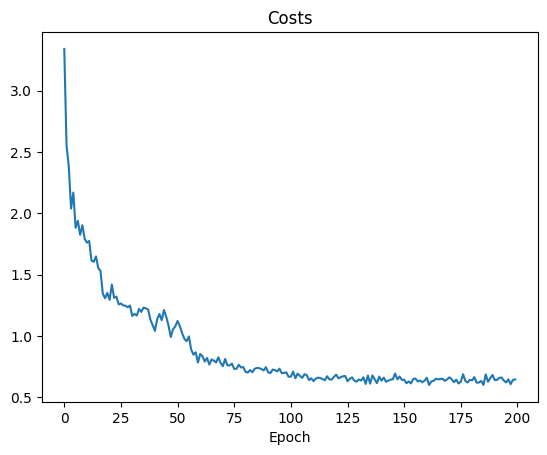

In [8]:
plt.plot(costs)
plt.xlabel("Epoch")
plt.title('Costs')

Text(0.5, 1.0, 'Validation Error Rates')

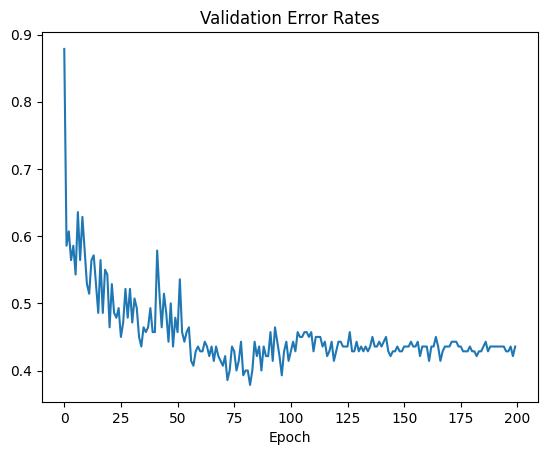

In [9]:
plt.plot(val_error_rates)
plt.xlabel("Epoch")
plt.title('Validation Error Rates')

Text(0.5, 1.0, 'Learning Rates')

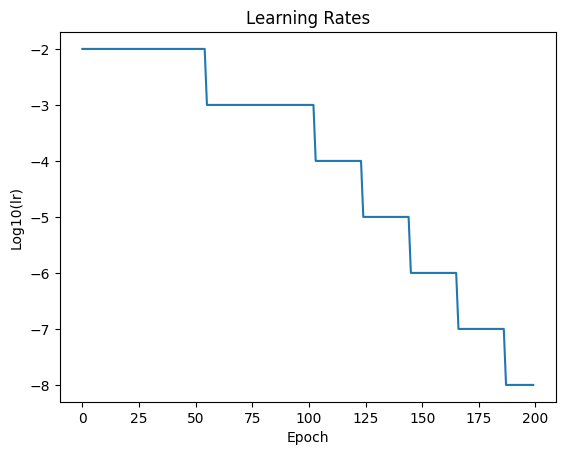

In [10]:
import math

plt.plot([math.log10(lr) for lr in learning_rates])
plt.ylabel("Log10(lr)")
plt.xlabel("Epoch")
plt.title('Learning Rates')